In [1]:
import tensorflow as tf
import os
import time
import scipy
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from layers import *

In [2]:
def show_images(images):
    if images.shape[3] == 3:
        
        c = images.shape[3]
        images = np.reshape(images, [images.shape[0], -1])
        sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
        sqrtimg = int(np.ceil(np.sqrt(images.shape[1]/c)))
        fig = plt.figure(figsize = (7,7))
        gs = gridspec.GridSpec(sqrtn, sqrtn)
        gs.update(wspace = 0.05, hspace = 0.05)
    
        for i, img in enumerate(images):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(img.reshape([sqrtimg,sqrtimg,c]))
    else:
        images = np.reshape(images, [images.shape[0], -1])
        sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
        sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
        fig = plt.figure(figsize = (7, 7))
        gs = gridspec.GridSpec(sqrtn, sqrtn)
        gs.update(wspace = 0.05, hspace = 0.05)
    
        for i, img in enumerate(images):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 
        
    

In [3]:
mnist = input_data.read_data_sets('./data/mnist', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [8]:
class cGAN:
    
    def __init__(self,batch_size, epoch):
        self.batch_size = batch_size
        self.training_epoch = epoch
        self.learning_rate = 0.0002
        self.y_dims = 10
        self.noise_size = 100
        self.sample_size = 100
        self.beta1 = 0.5
        self.check_point_dir = './check_point/cGAN'
        
        

    def generator(self,z,y,reuse = True, is_train = True):
        # generator architecture : concat -> fc(7*7*128) -> conv_tran(64) -> conv_train(1)
        with tf.variable_scope("generator", reuse = reuse):
            y = tf.concat([z,y], axis = 1)
            net = dense(y, 7*7*128,"g_1")
            net = bn(net,is_train = is_train)
            net = tf.nn.relu(net)
            net = tf.reshape(net, [-1, 7,7,128])
            net = conv_trans(net, 64,4,2,"g_2")
            net = bn(net,is_train=is_train)
            net = tf.nn.relu(net)
            net = conv_trans(net, 1,4,2,"g_3")
            net = tf.nn.sigmoid(net)
        return net
        

    def discriminator(self, x,y,reuse = True, is_train = True):
        # discriminator architecture : concat_image -> conv(64) -> conv(128) -> fc(1)
        with tf.variable_scope("discriminator",reuse = reuse):
            y = tf.reshape(y, [self.batch_size,1,1,10])
            x = conv_concat(x,y)
            net = lrelu(conv(x, filters = 64,kernel_size=4, strides = 2,name = "d_1"))
            net = lrelu(bn(conv(net, filters= 128,kernel_size=4, strides=2, name = "d_2"),is_train))
            net = tf.layers.flatten(net)
            net = dense(net, units = 1,name="d_3")
        return net
    
    
    def build_model(self):
        self.x = tf.placeholder(tf.float32, shape = [None,784])
        self.y = tf.placeholder(tf.float32, shape = [None,10])
        self.z = tf.placeholder(tf.float32, shape = [None, self.noise_size])
        
        self.x_img = tf.reshape(self.x, shape= [self.batch_size,28,28,1])
        
        
    def loss_op(self):
        # define Loss function and Optimizer
        self.g = self.generator(self.z,self.y,reuse= False)
        real_logits = self.discriminator(self.x_img, self.y,reuse = False)
        fake_logits = self.discriminator(self.g, self.y,reuse = True)
        
        
        d_fake_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_logits,
                                                    labels = tf.zeros_like(fake_logits)))
        d_real_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits = real_logits,
                                                   labels = tf.ones_like(real_logits)))
        
        self.d_loss = d_fake_loss + d_real_loss
        
        self.g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_logits,
                                                    labels =tf.ones_like(real_logits)))
        
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if 'd_' in var.name]
        g_vars = [var for var in t_vars if 'g_' in var.name]
        
        
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            self.d_trainer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1 = self.beta1).minimize(self.d_loss, var_list = d_vars)
            self.g_trainer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1 = self.beta1).minimize(self.g_loss, var_list = g_vars)
        
        self.images = self.generator(self.z,self.y,reuse = True)
        
    def train(self):
        self.build_model()
        self.loss_op()
        self.saver = tf.train.Saver()
        init = tf.global_variables_initializer()
        self.sample_noise = np.random.uniform(-1,1,size =(self.batch_size,self.noise_size))
        self.sample_labels = np.zeros([self.batch_size, self.y_dims])
        for i in range(10):
            self.sample_labels[i*10:(i+1)*10,i] = 1
        
        
        #self.saver = tf.train.Saver()
        
        start_time = time.time()
        with tf.Session() as sess:
            sess.run(init)
            if not os.path.exists("./sample_images/cGAN"):
                os.mkdir("./sample_images/cGAN")
            
            for epoch in range(self.training_epoch):
                total_batch = int(mnist.train.num_examples/self.batch_size)
                for iteration in range(total_batch):
                    batch_xs, batch_ys = mnist.train.next_batch(self.batch_size)
                    random_noise = np.random.uniform(-1,1,size = [self.batch_size, self.noise_size])
                    
                    _, d_loss_val = sess.run([self.d_trainer, self.d_loss], 
                                             feed_dict = {self.x:batch_xs, self.y:batch_ys, self.z : random_noise})
                    _, g_loss_val = sess.run([self.g_trainer, self.g_loss], 
                                             feed_dict = {self.x:batch_xs, self.y:batch_ys, self.z:random_noise})
                    
                    if iteration % 50 == 0:
                        print("Epoch : {},  Iteration : {},  D_loss : {},  G_loss : {} ".format(epoch, iteration, d_loss_val, g_loss_val))
                
                print(time.time() - start_time)
                samples = sess.run(self.g, feed_dict = {self.z: self.sample_noise, self.y: self.sample_labels})
                
                tot_num_samples = min(self.sample_size, self.batch_size)
                
                manifold_h = int(np.floor(np.sqrt(tot_num_samples)))
                manifold_w = int(np.floor(np.sqrt(tot_num_samples)))
                save_images(samples[:manifold_h*manifold_w,:,:,:],[manifold_h,manifold_w],
                           './sample_images/cGAN/{}_{}.png'.format(epoch,iteration))
                self.save_model(sess,self.check_point_dir,epoch)
                show_images(samples)
                plt.show()
            self.save_model(sess, self.check_point_dir, epoch)
                
    def save_model(self,sess, check_point_dir, step):
        check_point_dir = os.path.join(check_point_dir,"cGAN_model")
        
        if not os.path.exists(check_point_dir):
            os.makedirs(check_point_dir)
        
        self.saver.save(sess, os.path.join(check_point_dir),global_step = step)
        
    
                             
                
                

In [9]:
tf.reset_default_graph()

In [10]:
a = cGAN(100,10)

Epoch : 0,  Iteration : 0,  D_loss : 1.416085958480835,  G_loss : 0.7489671111106873 
Epoch : 0,  Iteration : 50,  D_loss : 0.2680392265319824,  G_loss : 2.3014161586761475 
Epoch : 0,  Iteration : 100,  D_loss : 0.18622249364852905,  G_loss : 2.8394296169281006 
Epoch : 0,  Iteration : 150,  D_loss : 0.23301884531974792,  G_loss : 2.4374561309814453 
Epoch : 0,  Iteration : 200,  D_loss : 0.49572399258613586,  G_loss : 1.4440187215805054 
Epoch : 0,  Iteration : 250,  D_loss : 0.8072618246078491,  G_loss : 2.2571969032287598 
Epoch : 0,  Iteration : 300,  D_loss : 0.7912075519561768,  G_loss : 1.991753101348877 
Epoch : 0,  Iteration : 350,  D_loss : 0.8262046575546265,  G_loss : 1.114932656288147 
Epoch : 0,  Iteration : 400,  D_loss : 0.9066784381866455,  G_loss : 1.2637656927108765 
Epoch : 0,  Iteration : 450,  D_loss : 1.087932825088501,  G_loss : 1.738440752029419 
Epoch : 0,  Iteration : 500,  D_loss : 1.014062523841858,  G_loss : 1.0151702165603638 
88.37606716156006


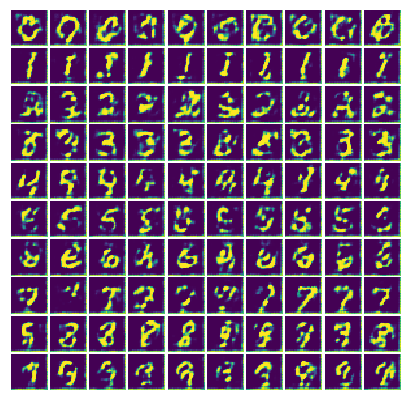

Epoch : 1,  Iteration : 0,  D_loss : 1.0727784633636475,  G_loss : 0.7882006764411926 
Epoch : 1,  Iteration : 50,  D_loss : 1.0178501605987549,  G_loss : 1.3490031957626343 
Epoch : 1,  Iteration : 100,  D_loss : 1.1699490547180176,  G_loss : 1.3350520133972168 
Epoch : 1,  Iteration : 150,  D_loss : 1.0797064304351807,  G_loss : 0.938310980796814 
Epoch : 1,  Iteration : 200,  D_loss : 1.0764803886413574,  G_loss : 0.8796296119689941 
Epoch : 1,  Iteration : 250,  D_loss : 1.0745230913162231,  G_loss : 0.6378882527351379 
Epoch : 1,  Iteration : 300,  D_loss : 1.0785564184188843,  G_loss : 1.2256975173950195 
Epoch : 1,  Iteration : 350,  D_loss : 1.2127324342727661,  G_loss : 0.6691814661026001 
Epoch : 1,  Iteration : 400,  D_loss : 1.130164384841919,  G_loss : 1.0486470460891724 
Epoch : 1,  Iteration : 450,  D_loss : 1.0582759380340576,  G_loss : 1.014843463897705 
Epoch : 1,  Iteration : 500,  D_loss : 1.1542140245437622,  G_loss : 0.721890389919281 
181.3684675693512


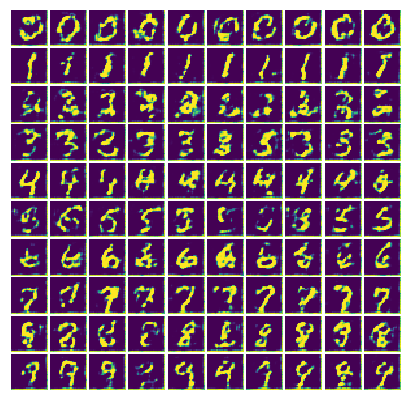

Epoch : 2,  Iteration : 0,  D_loss : 1.1335170269012451,  G_loss : 0.7147462368011475 
Epoch : 2,  Iteration : 50,  D_loss : 1.127410888671875,  G_loss : 1.394985556602478 
Epoch : 2,  Iteration : 100,  D_loss : 1.072372317314148,  G_loss : 1.1088669300079346 
Epoch : 2,  Iteration : 150,  D_loss : 1.023829460144043,  G_loss : 0.8768470883369446 
Epoch : 2,  Iteration : 200,  D_loss : 1.1308649778366089,  G_loss : 1.4775325059890747 
Epoch : 2,  Iteration : 250,  D_loss : 1.1718101501464844,  G_loss : 1.372419834136963 
Epoch : 2,  Iteration : 300,  D_loss : 1.074042558670044,  G_loss : 1.0961940288543701 
Epoch : 2,  Iteration : 350,  D_loss : 1.0879433155059814,  G_loss : 1.0383427143096924 
Epoch : 2,  Iteration : 400,  D_loss : 1.0396119356155396,  G_loss : 1.0061919689178467 
Epoch : 2,  Iteration : 450,  D_loss : 1.1807938814163208,  G_loss : 0.6943067312240601 
Epoch : 2,  Iteration : 500,  D_loss : 1.0969939231872559,  G_loss : 1.4323536157608032 
274.4133677482605


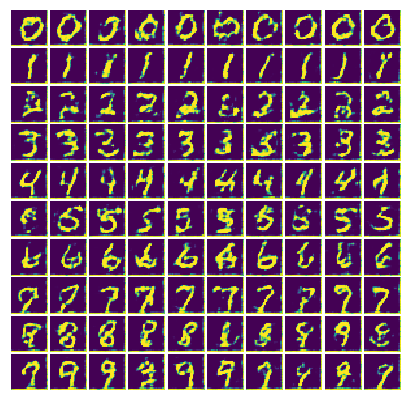

Epoch : 3,  Iteration : 0,  D_loss : 1.1967638731002808,  G_loss : 1.4107856750488281 
Epoch : 3,  Iteration : 50,  D_loss : 1.2168352603912354,  G_loss : 0.7113299369812012 
Epoch : 3,  Iteration : 100,  D_loss : 1.0569024085998535,  G_loss : 1.030419945716858 
Epoch : 3,  Iteration : 150,  D_loss : 1.1099367141723633,  G_loss : 1.3234339952468872 
Epoch : 3,  Iteration : 200,  D_loss : 1.175138235092163,  G_loss : 0.7243659496307373 
Epoch : 3,  Iteration : 250,  D_loss : 1.0906363725662231,  G_loss : 1.0177698135375977 
Epoch : 3,  Iteration : 300,  D_loss : 1.1121221780776978,  G_loss : 1.306972622871399 
Epoch : 3,  Iteration : 350,  D_loss : 1.1288949251174927,  G_loss : 0.7909845113754272 
Epoch : 3,  Iteration : 400,  D_loss : 1.1005125045776367,  G_loss : 0.8697637915611267 
Epoch : 3,  Iteration : 450,  D_loss : 1.0541391372680664,  G_loss : 1.2482789754867554 
Epoch : 3,  Iteration : 500,  D_loss : 1.0929617881774902,  G_loss : 1.137010931968689 
367.39999890327454


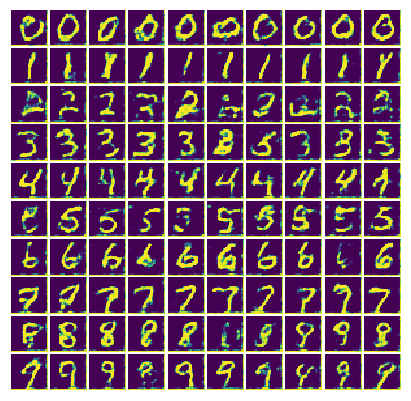

Epoch : 4,  Iteration : 0,  D_loss : 1.1940860748291016,  G_loss : 1.0095231533050537 
Epoch : 4,  Iteration : 50,  D_loss : 1.1044120788574219,  G_loss : 1.4752010107040405 
Epoch : 4,  Iteration : 100,  D_loss : 1.2863504886627197,  G_loss : 1.3432393074035645 
Epoch : 4,  Iteration : 150,  D_loss : 1.1371266841888428,  G_loss : 1.0326367616653442 
Epoch : 4,  Iteration : 200,  D_loss : 1.1204756498336792,  G_loss : 1.4316368103027344 
Epoch : 4,  Iteration : 250,  D_loss : 1.1849483251571655,  G_loss : 1.283636450767517 
Epoch : 4,  Iteration : 300,  D_loss : 1.2593178749084473,  G_loss : 1.2357558012008667 
Epoch : 4,  Iteration : 350,  D_loss : 1.2264734506607056,  G_loss : 1.1695582866668701 
Epoch : 4,  Iteration : 400,  D_loss : 1.21012544631958,  G_loss : 0.732466459274292 
Epoch : 4,  Iteration : 450,  D_loss : 1.19765305519104,  G_loss : 0.6899340152740479 
Epoch : 4,  Iteration : 500,  D_loss : 1.136765718460083,  G_loss : 0.9367349743843079 
460.5034861564636


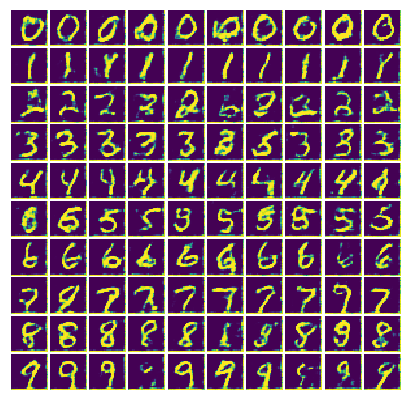

Epoch : 5,  Iteration : 0,  D_loss : 1.1753227710723877,  G_loss : 1.0189714431762695 
Epoch : 5,  Iteration : 50,  D_loss : 1.1460824012756348,  G_loss : 1.168321967124939 
Epoch : 5,  Iteration : 100,  D_loss : 1.192859411239624,  G_loss : 1.066175937652588 
Epoch : 5,  Iteration : 150,  D_loss : 1.261176586151123,  G_loss : 1.250454068183899 
Epoch : 5,  Iteration : 200,  D_loss : 1.146878957748413,  G_loss : 1.097216010093689 
Epoch : 5,  Iteration : 250,  D_loss : 1.1754366159439087,  G_loss : 1.1779708862304688 
Epoch : 5,  Iteration : 300,  D_loss : 1.1949679851531982,  G_loss : 0.9298153519630432 
Epoch : 5,  Iteration : 350,  D_loss : 1.3073554039001465,  G_loss : 0.606864869594574 
Epoch : 5,  Iteration : 400,  D_loss : 1.2283854484558105,  G_loss : 1.2038230895996094 
Epoch : 5,  Iteration : 450,  D_loss : 1.2505075931549072,  G_loss : 0.9514636397361755 
Epoch : 5,  Iteration : 500,  D_loss : 1.1542794704437256,  G_loss : 0.75689697265625 
553.2582869529724


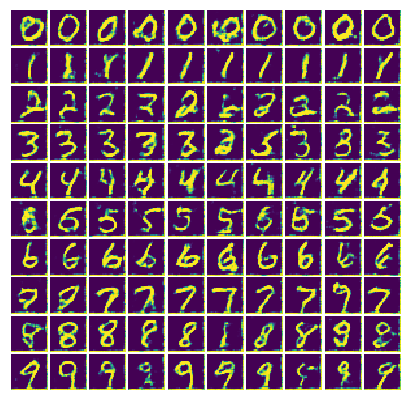

Epoch : 6,  Iteration : 0,  D_loss : 1.1239138841629028,  G_loss : 0.7903842329978943 
Epoch : 6,  Iteration : 50,  D_loss : 1.2004616260528564,  G_loss : 0.8059810400009155 
Epoch : 6,  Iteration : 100,  D_loss : 1.279306411743164,  G_loss : 1.3424315452575684 
Epoch : 6,  Iteration : 150,  D_loss : 1.228898048400879,  G_loss : 1.0887527465820312 
Epoch : 6,  Iteration : 200,  D_loss : 1.1754271984100342,  G_loss : 0.7943704128265381 
Epoch : 6,  Iteration : 250,  D_loss : 1.2502927780151367,  G_loss : 1.0011887550354004 
Epoch : 6,  Iteration : 300,  D_loss : 1.2770466804504395,  G_loss : 1.221720576286316 
Epoch : 6,  Iteration : 350,  D_loss : 1.2405366897583008,  G_loss : 0.8752838373184204 
Epoch : 6,  Iteration : 400,  D_loss : 1.255479097366333,  G_loss : 1.1488592624664307 
Epoch : 6,  Iteration : 450,  D_loss : 1.1937123537063599,  G_loss : 0.6815193891525269 
Epoch : 6,  Iteration : 500,  D_loss : 1.218980312347412,  G_loss : 0.7015329003334045 
644.1814301013947


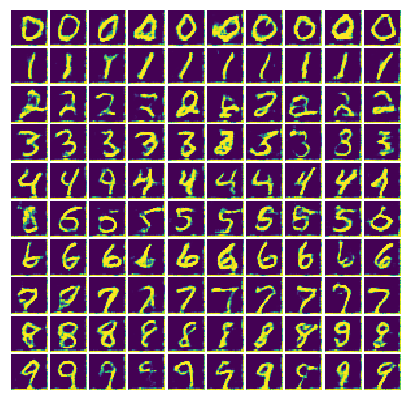

Epoch : 7,  Iteration : 0,  D_loss : 1.264037847518921,  G_loss : 1.1965752840042114 
Epoch : 7,  Iteration : 50,  D_loss : 1.200758934020996,  G_loss : 0.7348652482032776 
Epoch : 7,  Iteration : 100,  D_loss : 1.2325952053070068,  G_loss : 0.7428068518638611 
Epoch : 7,  Iteration : 150,  D_loss : 1.2399017810821533,  G_loss : 1.218116283416748 
Epoch : 7,  Iteration : 200,  D_loss : 1.2415988445281982,  G_loss : 0.6737657189369202 
Epoch : 7,  Iteration : 250,  D_loss : 1.171318769454956,  G_loss : 1.0016429424285889 
Epoch : 7,  Iteration : 300,  D_loss : 1.1956019401550293,  G_loss : 0.6705881357192993 
Epoch : 7,  Iteration : 350,  D_loss : 1.3324793577194214,  G_loss : 0.9910779595375061 
Epoch : 7,  Iteration : 400,  D_loss : 1.255596399307251,  G_loss : 1.0956696271896362 
Epoch : 7,  Iteration : 450,  D_loss : 1.2802168130874634,  G_loss : 0.7945583462715149 
Epoch : 7,  Iteration : 500,  D_loss : 1.176649808883667,  G_loss : 1.0088326930999756 
735.3673784732819


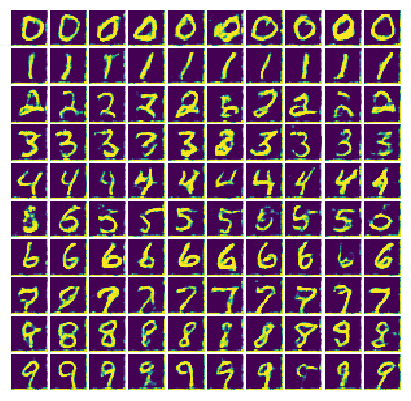

Epoch : 8,  Iteration : 0,  D_loss : 1.2146646976470947,  G_loss : 0.9236769676208496 
Epoch : 8,  Iteration : 50,  D_loss : 1.1945784091949463,  G_loss : 0.9605903029441833 
Epoch : 8,  Iteration : 100,  D_loss : 1.2661378383636475,  G_loss : 1.1256937980651855 
Epoch : 8,  Iteration : 150,  D_loss : 1.2712126970291138,  G_loss : 0.9539415836334229 
Epoch : 8,  Iteration : 200,  D_loss : 1.2400652170181274,  G_loss : 1.2332383394241333 
Epoch : 8,  Iteration : 250,  D_loss : 1.1954097747802734,  G_loss : 1.290234088897705 
Epoch : 8,  Iteration : 300,  D_loss : 1.260229468345642,  G_loss : 0.6367597579956055 
Epoch : 8,  Iteration : 350,  D_loss : 1.2085886001586914,  G_loss : 0.7686313390731812 
Epoch : 8,  Iteration : 400,  D_loss : 1.2252681255340576,  G_loss : 1.340108036994934 
Epoch : 8,  Iteration : 450,  D_loss : 1.2100560665130615,  G_loss : 1.186997890472412 
Epoch : 8,  Iteration : 500,  D_loss : 1.2038991451263428,  G_loss : 1.0175623893737793 
827.0670552253723


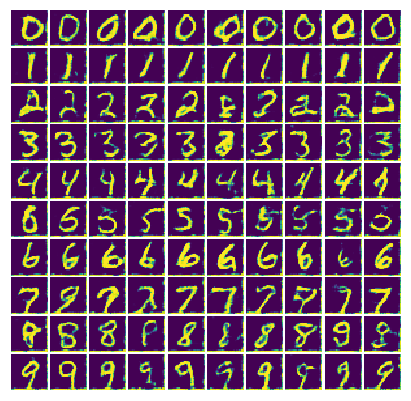

Epoch : 9,  Iteration : 0,  D_loss : 1.211077332496643,  G_loss : 0.9835453033447266 
Epoch : 9,  Iteration : 50,  D_loss : 1.3007357120513916,  G_loss : 1.6118452548980713 
Epoch : 9,  Iteration : 100,  D_loss : 1.2611417770385742,  G_loss : 0.9483438730239868 
Epoch : 9,  Iteration : 150,  D_loss : 1.255226492881775,  G_loss : 1.0156713724136353 
Epoch : 9,  Iteration : 200,  D_loss : 1.2332966327667236,  G_loss : 0.7827929854393005 
Epoch : 9,  Iteration : 250,  D_loss : 1.189143419265747,  G_loss : 0.9717434048652649 
Epoch : 9,  Iteration : 300,  D_loss : 1.2687574625015259,  G_loss : 1.2413392066955566 
Epoch : 9,  Iteration : 350,  D_loss : 1.2705037593841553,  G_loss : 0.6203639507293701 
Epoch : 9,  Iteration : 400,  D_loss : 1.3221631050109863,  G_loss : 0.6425024271011353 
Epoch : 9,  Iteration : 450,  D_loss : 1.171861171722412,  G_loss : 1.2694487571716309 
Epoch : 9,  Iteration : 500,  D_loss : 1.2030115127563477,  G_loss : 1.119797945022583 
919.6455171108246


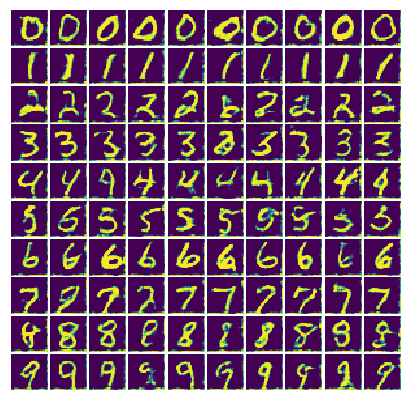

In [11]:
a.train()